# Introduction

### State Objective Here:
        Pinpoint any patterns that can potentially spot churning clients so we can deploy a marketing plan of promo codes and special plan options that can encourage a client to stay loyal to Interconnect.
    
### State Goals Here:
        Transform the raw data into clean data.
        Narrow down churning demographic vs the non-churning demographic based on their provided characteristics.
        Analyze the churning demographic to gain insights on any potential reason why they would decide to leave.
        After completing the Data Wrangling & EDA, proceed into the ML phase and experiment with 3 different models.
    
### Initial Questions:
        Can we easily identify clear, distinct characterisitics of potential churning clients?
        If not, is possible to retrieve more or are we limited to what is already provided?
        Q3

In [1]:
# Load Libraries here
import pandas as pd
import numpy as np
import math as mt
import seaborn as sns
from datetime import datetime
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
# Load Dataset(s) here
contract = pd.read_csv('/datasets/contract.csv')
personal = pd.read_csv('/datasets/personal.csv')
internet = pd.read_csv('/datasets/internet.csv')
phone = pd.read_csv('/datasets/phone.csv')

In [3]:
# this function retrieves info on...
def dataset_info(df):
    # Potential Dups
    print("..... Duplicate Rows .....")
    print(f'Total Duplicates: {df.duplicated().sum()}\n')

    # A DF's Shape
    print("\n..... DataFrame Shape .....")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\n")
    
    # Potential missing values 
    print("..... Missing Values .....")
    print(df.isna().sum(), '\n')
    
    # A DF's basic info
    print("..... DataFrame Information .....") 
    df.info()
    print("\n")
     
    # Any particular column's unique values
    print("..... Unique Values per Column .....")
    for column in df.columns:
        unique_vals = df[column].nunique()
        print(f'{column}: {unique_vals} unique values')
    print("\n")

    # A DF's first 10 rows
    print("..... DataFrame Head .....")
    display(df.head(10))
    
    # A DF's 10 Sample rows
    print("..... DataFrame's Sampled Rows .....")
    display(df.sample(10))
    return

In [4]:
def time_cut(df, time_column):
    cutoff_date = pd.to_datetime('2020-02-01')
    df[time_column] = pd.to_datetime(df[time_column], errors='coerce')
    df_filtered = df[df[time_column] <= cutoff_date]
    return df_filtered

In [5]:
def encode_datetime_string_column(column):
    datetime_series = pd.to_datetime(column, errors='coerce')
    encoded_column = datetime_series.notna().astype(int)
    return encoded_column

# Data Wrangling

Here in the Data Wrangling section, overall, I went ahead and... 
* Cleaned the Data:
	- Corrected Missing, Inconsistent and Duplicated Data (date formats, filled/remove missing values, drop dup columns).
* Transformed the Data:
	- Feature Engineered columns (new tenure column, binary churn column, categorical data's numerical identity and parsed customer ids)
* Integrated the Data:
	- Merged all 4 datasets based on the stringed customer ID column
* Validated the Data:
	- I created a master "data inspector" function that ensures me to catch any faulty values early on that could be hidden out of view while also previewing its other attributes, which can be found above. Along with a Time Truncator intented to condense the dataframe to (or before) Feb 1, 2020.
    
    
    
All of this was done in 3 sections to get a fully merged, cleaned dataframe.

Here in this first section: 
- I noticed both the Internet & Contract datasets had timestamp-like objects *as objects* (In Session Date, and Begin & End Date) and converted them over to their proper datatype: datetime64[ns]. However after taking note of the Contract's End Date column: 1) it indicates a customer's churn date or not 2) it didn't convert over to its correct datatype given the "No" comments, I will maintain that datetype for the time being.

- I also transformed here, all of the datasets' mutual Customer/User ID columns through converting them all to a string data type and with the "data_info" function I validated that all datasets columns didn't introduce any errors within the dataframe.

In [6]:
# this is where I strip the ID's respective columns where it 
# returns only a numerical value to match across all DFs
personal['customerID'] = personal['customerID'].astype(str)
phone['customerID'] = phone['customerID'].astype(str)
contract['customerID'] = contract['customerID'].astype(str)
internet['user_id'] = internet['user_id'].astype(str)

# I convert the respective datetime columns (BeginDate & Session_Date) but realized the 'No'
# comment preventing the End Date column in the Contract dataset so I will keep it as is for now.
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce').fillna('No')
internet['session_date'] = pd.to_datetime(internet['session_date'])

In [7]:
dataset_info(contract)

..... Duplicate Rows .....
Total Duplicates: 0


..... DataFrame Shape .....
Rows: 7043, Columns: 8


..... Missing Values .....
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64 

..... DataFrame Information .....
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


..... DataFrame's Sampled Rows .....


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1880,6474-FVJLC,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,86.00,165.45
6449,7601-WFVZV,2020-01-01,No,Month-to-month,No,Mailed check,19.55,19.55
3620,9373-WSLOY,2017-05-01,No,Month-to-month,Yes,Electronic check,50.00,1750.85
2228,3597-YASZG,2014-04-01,No,Two year,Yes,Bank transfer (automatic),104.45,7349.35
1670,5047-LHVLY,2019-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Mailed check,50.15,50.15
3513,4063-EIKNQ,2019-03-01,No,Month-to-month,No,Bank transfer (automatic),20.95,267.35
4887,9184-GALIL,2016-12-01,No,Month-to-month,No,Mailed check,20.45,781.25
5460,6551-VLJMV,2017-04-01,No,Two year,No,Credit card (automatic),20.05,679
631,9931-KGHOA,2016-04-01,No,Month-to-month,No,Bank transfer (automatic),55.00,2473.95
6458,9644-UMGQA,2019-08-01,No,Month-to-month,Yes,Electronic check,49.15,295.65


In [8]:
dataset_info(personal)

..... Duplicate Rows .....
Total Duplicates: 0


..... DataFrame Shape .....
Rows: 7043, Columns: 5


..... Missing Values .....
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64 

..... DataFrame Information .....
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


..... Unique Values per Column .....
customerID: 7043 unique values
gender: 2 unique values
SeniorCitizen: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values


..... DataFrame Head .....


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


..... DataFrame's Sampled Rows .....


,customerID,gender,SeniorCitizen,Partner,Dependents
1020,1452-XRSJV,Female,0,Yes,Yes
4189,7103-ZGVNT,Female,0,Yes,Yes
873,5073-WXOYN,Female,0,No,No
3177,1814-WFGVS,Male,0,Yes,Yes
101,3679-XASPY,Female,0,Yes,Yes
3683,7688-AWMDX,Male,0,Yes,No
3245,0461-CVKMU,Female,0,Yes,Yes
2826,3638-DIMPH,Female,0,Yes,No
448,5168-MSWXT,Male,0,Yes,Yes
4178,1209-VFFOC,Male,0,Yes,Yes


In [9]:
dataset_info(phone)

..... Duplicate Rows .....
Total Duplicates: 0


..... DataFrame Shape .....
Rows: 6361, Columns: 2


..... Missing Values .....
customerID       0
MultipleLines    0
dtype: int64 

..... DataFrame Information .....
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


..... Unique Values per Column .....
customerID: 6361 unique values
MultipleLines: 2 unique values


..... DataFrame Head .....


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


..... DataFrame's Sampled Rows .....


,customerID,MultipleLines
5709,1597-LHYNC,Yes
4726,8382-SHQEH,Yes
892,9369-XFEHK,Yes
3968,4781-ZXYGU,No
4101,9274-UARKJ,No
1313,5514-YQENT,No
1621,2307-FYNNL,Yes
149,6345-FZOQH,No
1545,8593-WHYHV,Yes
2022,7036-TYDEC,Yes


In [10]:
dataset_info(internet)

..... Duplicate Rows .....
Total Duplicates: 0


..... DataFrame Shape .....
Rows: 149396, Columns: 5


..... Missing Values .....
Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64 

..... DataFrame Information .....
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 5.7+ MB


..... Unique Values per Column .....
Unnamed: 0: 149396 unique values
id: 149396 unique values
mb_used: 70003 unique values
session_date: 365 unique values
user_id: 497 unique valu

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


..... DataFrame's Sampled Rows .....


,Unnamed: 0,id,mb_used,session_date,user_id
21394,21394,1072_117,237.82,2018-07-02,1072
131761,131761,1437_287,279.84,2018-09-02,1437
80641,80641,1272_33,234.32,2018-09-16,1272
107993,107993,1369_22,288.57,2018-09-04,1369
93176,93176,1314_530,403.92,2018-07-03,1314
117312,117312,1394_270,0.00,2018-10-19,1394
96932,96932,1326_295,413.24,2018-12-11,1326
97251,97251,1327_172,526.43,2018-06-27,1327
140832,140832,1472_506,10.71,2018-12-26,1472
139499,139499,1468_293,585.13,2018-02-13,1468


In this second section, linearly: 
* I inner merged contract with personal first, and then once those two were combined, I then left merged phone together into the new dataframe. Lastly, I left merged the internet to create the fully, merged dataframe and yield a dataframe with *7,043 rows with 14 columns*. After ensuring the dataframes were succesfully combined I filled in the NaN values and drop unneeded columns that came from merging the dataframes.

In [11]:
merged_cp = contract.merge(personal, on='customerID', how='inner')
merged_cpp = merged_cp.merge(phone, on='customerID', how='left')
full_data = merged_cpp.merge(internet, left_on='customerID', right_on='user_id', how='left')
full_data = full_data.drop(columns=['Unnamed: 0', 'id', 'session_date','user_id', ])
full_data = full_data.fillna(0)
print(full_data.shape)

(7043, 14)


In [12]:
dataset_info(full_data)

..... Duplicate Rows .....
Total Duplicates: 0


..... DataFrame Shape .....
Rows: 7043, Columns: 14


..... Missing Values .....
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
mb_used             0
dtype: int64 

..... DataFrame Information .....
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,mb_used
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,0,0.0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,No,0.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,0.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,0,0.0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,0.0
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Yes,0.0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Yes,0.0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,Female,0,No,No,0,0.0
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Yes,0.0
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,No,0.0


..... DataFrame's Sampled Rows .....


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,mb_used
5059,6907-NZZIJ,2016-12-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,99.15,3615.6,Female,0,No,No,Yes,0.0
6811,8992-JQYUN,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,50.35,50.35,Male,0,Yes,No,0,0.0
5043,4325-NFSKC,2018-03-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,90.60,1660,Male,1,No,No,Yes,0.0
6959,1024-KPRBB,2016-12-01,No,One year,Yes,Mailed check,89.10,3342,Female,0,No,No,No,0.0
1611,1971-DTCZB,2014-02-01,No,Two year,Yes,Bank transfer (automatic),90.95,6468.6,Female,0,Yes,No,Yes,0.0
5094,6266-QHOJZ,2014-09-01,No,One year,Yes,Electronic check,89.85,5844.65,Female,0,No,No,Yes,0.0
6736,7558-IMLMT,2014-07-01,No,Two year,Yes,Mailed check,20.80,1411.9,Male,0,Yes,Yes,No,0.0
1277,4821-WQOYN,2014-02-01,No,Two year,Yes,Credit card (automatic),20.10,1326.25,Female,0,Yes,Yes,No,0.0
5796,8571-ZCMCX,2016-03-01,No,Two year,Yes,Credit card (automatic),60.00,2768.65,Female,0,Yes,Yes,0,0.0
5707,4537-DKTAL,2019-12-01,No,Month-to-month,No,Electronic check,45.55,84.4,Female,0,No,No,No,0.0


In [13]:
# this converts the column's values into datetimes and anything not a datetime value is given NaT
# this is why we're seeing 226k null valus which are the customers who are current loyal customers
full_data['EndDate'] = pd.to_datetime(full_data['EndDate'], errors='coerce')
dataset_info(full_data)

..... Duplicate Rows .....
Total Duplicates: 0


..... DataFrame Shape .....
Rows: 7043, Columns: 14


..... Missing Values .....
customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines          0
mb_used                0
dtype: int64 

..... DataFrame Information .....
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   o

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,mb_used
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,0,0.0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,No,0.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,0.0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,0,0.0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,0.0
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Yes,0.0
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Yes,0.0
7,6713-OKOMC,2019-04-01,NaT,Month-to-month,No,Mailed check,29.75,301.9,Female,0,No,No,0,0.0
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Yes,0.0
9,6388-TABGU,2014-12-01,NaT,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,No,0.0


..... DataFrame's Sampled Rows .....


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,mb_used
5943,2202-CUYXZ,2019-10-01,2019-11-01,Month-to-month,Yes,Electronic check,84.85,84.85,Male,0,No,No,No,0.0
3049,0268-QKIWO,2019-09-01,2019-12-01,Month-to-month,No,Electronic check,19.75,58.85,Female,0,No,No,No,0.0
5924,2236-HILPA,2014-12-01,NaT,Two year,No,Credit card (automatic),20.65,1218.45,Male,0,Yes,Yes,No,0.0
3094,1898-JSNDC,2016-11-01,NaT,One year,Yes,Credit card (automatic),58.60,2224.5,Female,0,No,No,No,0.0
270,4385-GZQXV,2018-06-01,2019-10-01,Month-to-month,Yes,Electronic check,94.45,1511.2,Female,1,No,No,No,0.0
2741,1724-BQUHA,2019-05-01,2019-10-01,Month-to-month,Yes,Electronic check,89.50,477.7,Male,1,No,No,No,0.0
4255,2157-MXBJS,2018-10-01,2019-11-01,One year,Yes,Mailed check,75.30,989.45,Male,0,Yes,No,Yes,0.0
5878,8909-BOLNL,2019-11-01,NaT,One year,No,Mailed check,21.20,52.05,Male,0,No,No,No,0.0
596,8208-EUMTE,2018-10-01,NaT,Two year,No,Mailed check,54.85,916.15,Male,0,No,No,0,0.0
2399,7176-WIONM,2019-02-01,NaT,Month-to-month,Yes,Bank transfer (automatic),49.85,617.15,Female,0,Yes,No,0,0.0


I decided to use 2020-02-01 as a replacement, cut off date for our customers who didn't leave yet as this day is the cut off for contract validation in terms of information. Given that, this'll narrow down the EndDate's column on whether or not a customer churned in another separate "churn" column's with a binary association mirroring the EndDate column.

In [14]:
column_name = 'EndDate' 
contract_cutoff = pd.Timestamp('2020-02-01') #no end date customers

if column_name in full_data.columns:
    full_data[column_name] = full_data[column_name].fillna(contract_cutoff)
else:
    print(f"Column '{column_name}' does not exist in the DataFrame.")

# Print the DataFrame to verify
dataset_info(full_data)

..... Duplicate Rows .....
Total Duplicates: 0


..... DataFrame Shape .....
Rows: 7043, Columns: 14


..... Missing Values .....
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
mb_used             0
dtype: int64 

..... DataFrame Information .....
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,mb_used
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,0,0.0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,No,0.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,0.0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,0,0.0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,0.0
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Yes,0.0
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Yes,0.0
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,301.9,Female,0,No,No,0,0.0
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Yes,0.0
9,6388-TABGU,2014-12-01,2020-02-01,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,No,0.0


..... DataFrame's Sampled Rows .....


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,mb_used
3026,6127-ISGTU,2018-09-01,2020-01-01,Month-to-month,Yes,Electronic check,84.95,1378.25,Female,0,Yes,No,Yes,0.0
2021,0181-RITDD,2014-12-01,2020-02-01,Two year,No,Mailed check,108.15,6825.65,Male,0,Yes,Yes,No,0.0
3055,0617-FHSGK,2015-12-01,2020-01-01,Month-to-month,No,Credit card (automatic),75.20,3678.3,Male,0,No,Yes,Yes,0.0
4686,8024-XNAFQ,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),107.40,7748.75,Female,1,No,No,Yes,0.0
1161,5868-CZJDR,2019-12-01,2020-01-01,Month-to-month,Yes,Mailed check,31.35,31.35,Male,0,No,Yes,0,0.0
5705,3785-NRHYR,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,19.65,19.65,Male,0,No,No,No,0.0
1490,8016-ZMGMO,2014-08-01,2020-02-01,One year,Yes,Bank transfer (automatic),70.85,4738.85,Female,1,Yes,No,Yes,0.0
6524,2754-VDLTR,2018-12-01,2019-10-01,Month-to-month,No,Electronic check,95.20,930.4,Male,0,No,Yes,Yes,0.0
3558,8417-GSODA,2017-10-01,2020-02-01,One year,No,Bank transfer (automatic),92.20,2568.15,Male,0,Yes,Yes,Yes,0.0
2204,2659-VXMWZ,2014-05-01,2019-12-01,One year,Yes,Electronic check,111.30,7482.1,Male,0,Yes,Yes,Yes,0.0


In [15]:
full_data['churn'] = (full_data['EndDate'] == '2020-02-01').astype(int)
print(full_data['churn'].value_counts()) 
#Remember: 1 = No Churning/Loyal Customers; 0 = churning/disloyal customers
dataset_info(full_data)

1    5174
0    1869
Name: churn, dtype: int64
..... Duplicate Rows .....
Total Duplicates: 0


..... DataFrame Shape .....
Rows: 7043, Columns: 15


..... Missing Values .....
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
mb_used             0
churn               0
dtype: int64 

..... DataFrame Information .....
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   Paperless

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,mb_used,churn
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,0,0.0,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,No,0.0,1
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,0.0,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,0,0.0,1
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,0.0,0
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Yes,0.0,0
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Yes,0.0,1
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,301.9,Female,0,No,No,0,0.0,1
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Yes,0.0,0
9,6388-TABGU,2014-12-01,2020-02-01,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,No,0.0,1


..... DataFrame's Sampled Rows .....


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,mb_used,churn
4906,8639-NHQEI,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),95.90,6954.15,Female,0,Yes,Yes,Yes,0.0,1
3701,3812-LRZIR,2017-11-01,2020-02-01,Two year,No,Electronic check,24.50,761.95,Female,0,Yes,Yes,Yes,0.0,1
4917,6040-CGACY,2018-11-01,2020-02-01,Month-to-month,No,Mailed check,19.60,299.4,Female,0,No,No,No,0.0,1
4841,9058-MJLZC,2018-02-01,2020-02-01,Month-to-month,Yes,Electronic check,94.60,2283.15,Female,0,No,No,No,0.0,1
2979,8996-ZROXE,2015-05-01,2020-02-01,One year,Yes,Electronic check,53.50,3035.8,Male,1,No,No,No,0.0,1
6738,3590-TCXTB,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.35,20.35,Male,0,No,No,No,0.0,1
5802,3570-YUEKJ,2016-08-01,2020-02-01,Month-to-month,Yes,Electronic check,49.55,2077.95,Female,0,No,No,No,0.0,1
5186,3776-EKTKM,2019-09-01,2019-10-01,Month-to-month,Yes,Electronic check,36.45,36.45,Female,1,No,No,0,0.0,0
5042,1561-BWHIN,2018-07-01,2020-02-01,One year,No,Mailed check,19.80,344.5,Male,0,Yes,Yes,No,0.0,1
6016,4250-ZBWLV,2014-02-01,2019-10-01,One year,No,Electronic check,108.45,7176.55,Male,0,No,No,Yes,0.0,0


I went ahead and renamed and reordered the columns, and created a '3rd Option', called *No Phone Plan Service*, value for the Multiple Lines column since some customers didn't ever have a service plan.

In [16]:
# Created a dictionary for renaming and reordering
new_columns = {
    'customerID': 'customer_id',
    'churn': 'churn',
    'mb_used': 'mb_used',
    'MonthlyCharges': 'monthly_charges',
    'TotalCharges': 'total_charges',
    'BeginDate': 'begin_date',
    'EndDate': 'end_date',
    'Type': 'contract_type',
    'PaperlessBilling': 'paperless_billing',
    'PaymentMethod': 'payment_method',
    'gender': 'gender',
    'SeniorCitizen': 'senior_citizen',
    'Partner': 'partner',
    'Dependents': 'dependents',
    'MultipleLines': 'multiple_lines'
}

full_data = full_data.rename(columns=new_columns)[list(new_columns.values())]
full_data['multiple_lines'] = full_data['multiple_lines'].replace(0, 'No Phone Plan Service')
dataset_info(full_data)

..... Duplicate Rows .....
Total Duplicates: 0


..... DataFrame Shape .....
Rows: 7043, Columns: 15


..... Missing Values .....
customer_id          0
churn                0
mb_used              0
monthly_charges      0
total_charges        0
begin_date           0
end_date             0
contract_type        0
paperless_billing    0
payment_method       0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
dtype: int64 

..... DataFrame Information .....
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   churn              7043 non-null   int64         
 2   mb_used            7043 non-null   float64       
 3   monthly_charges    7043 non-null   float64       
 4   total_charges      7043 non-null  

,customer_id,churn,mb_used,monthly_charges,total_charges,begin_date,end_date,contract_type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,1,0.0,29.85,29.85,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,Female,0,Yes,No,No Phone Plan Service
1,5575-GNVDE,1,0.0,56.95,1889.5,2017-04-01,2020-02-01,One year,No,Mailed check,Male,0,No,No,No
2,3668-QPYBK,0,0.0,53.85,108.15,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,Male,0,No,No,No
3,7795-CFOCW,1,0.0,42.30,1840.75,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),Male,0,No,No,No Phone Plan Service
4,9237-HQITU,0,0.0,70.70,151.65,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,Female,0,No,No,No
5,9305-CDSKC,0,0.0,99.65,820.5,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,Female,0,No,No,Yes
6,1452-KIOVK,1,0.0,89.10,1949.4,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),Male,0,No,Yes,Yes
7,6713-OKOMC,1,0.0,29.75,301.9,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,Female,0,No,No,No Phone Plan Service
8,7892-POOKP,0,0.0,104.80,3046.05,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,Female,0,Yes,No,Yes
9,6388-TABGU,1,0.0,56.15,3487.95,2014-12-01,2020-02-01,One year,No,Bank transfer (automatic),Male,0,No,Yes,No


..... DataFrame's Sampled Rows .....


,customer_id,churn,mb_used,monthly_charges,total_charges,begin_date,end_date,contract_type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,multiple_lines
3702,4818-QIUFN,0,0.0,79.15,1520.9,2018-02-01,2019-10-01,Month-to-month,Yes,Electronic check,Female,1,No,No,Yes
1898,6689-TCZHQ,0,0.0,78.95,378.4,2019-07-01,2019-12-01,Month-to-month,No,Electronic check,Female,1,No,No,No
1152,4320-QMLLA,1,0.0,54.85,370.4,2019-07-01,2020-02-01,Month-to-month,No,Mailed check,Male,0,No,No,No
4447,7821-DPRQE,1,0.0,107.70,7320.9,2014-06-01,2020-02-01,Month-to-month,Yes,Electronic check,Male,0,Yes,No,Yes
3614,8039-EQPIM,1,0.0,60.25,4055.5,2014-05-01,2020-02-01,Two year,No,Bank transfer (automatic),Male,0,Yes,No,No Phone Plan Service
5284,3317-HRTNN,0,0.0,45.70,198,2019-06-01,2019-11-01,Month-to-month,No,Electronic check,Female,1,No,No,No Phone Plan Service
6187,0224-NIJLP,1,0.0,20.15,165.5,2019-06-01,2020-02-01,Two year,No,Mailed check,Male,0,Yes,Yes,No
716,0114-IGABW,1,0.0,58.25,4145.9,2014-03-01,2020-02-01,Two year,No,Bank transfer (automatic),Female,0,Yes,No,No Phone Plan Service
4463,4603-JANFB,0,0.0,69.85,69.85,2019-10-01,2019-11-01,Month-to-month,Yes,Electronic check,Male,0,No,No,No
2616,7593-JNWRU,0,0.0,44.60,260.8,2019-07-01,2020-01-01,Month-to-month,Yes,Bank transfer (automatic),Male,0,Yes,Yes,No


I also ensured that the numerical values in the charge and MB_used columns were the correct datatype and had a value of at least 0 or their true value rounded; thus, printed it out to make sure there were no potential errors as well. 

In [17]:
full_data['total_charges'] = pd.to_numeric(full_data['total_charges'], errors='coerce')
full_data['monthly_charges'] = pd.to_numeric(full_data['monthly_charges'], errors='coerce')
full_data['mb_used'] = pd.to_numeric(full_data['mb_used'], errors='coerce')
full_data.fillna(0, inplace=True)
full_data[['monthly_charges', 'mb_used', 'total_charges']] = full_data[['monthly_charges', 'mb_used', 'total_charges']].round().astype(int)

In [18]:
dataset_info(full_data)

..... Duplicate Rows .....
Total Duplicates: 0


..... DataFrame Shape .....
Rows: 7043, Columns: 15


..... Missing Values .....
customer_id          0
churn                0
mb_used              0
monthly_charges      0
total_charges        0
begin_date           0
end_date             0
contract_type        0
paperless_billing    0
payment_method       0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
dtype: int64 

..... DataFrame Information .....
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   churn              7043 non-null   int64         
 2   mb_used            7043 non-null   int64         
 3   monthly_charges    7043 non-null   int64         
 4   total_charges      7043 non-null  

,customer_id,churn,mb_used,monthly_charges,total_charges,begin_date,end_date,contract_type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,1,0,30,30,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,Female,0,Yes,No,No Phone Plan Service
1,5575-GNVDE,1,0,57,1890,2017-04-01,2020-02-01,One year,No,Mailed check,Male,0,No,No,No
2,3668-QPYBK,0,0,54,108,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,Male,0,No,No,No
3,7795-CFOCW,1,0,42,1841,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),Male,0,No,No,No Phone Plan Service
4,9237-HQITU,0,0,71,152,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,Female,0,No,No,No
5,9305-CDSKC,0,0,100,820,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,Female,0,No,No,Yes
6,1452-KIOVK,1,0,89,1949,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),Male,0,No,Yes,Yes
7,6713-OKOMC,1,0,30,302,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,Female,0,No,No,No Phone Plan Service
8,7892-POOKP,0,0,105,3046,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,Female,0,Yes,No,Yes
9,6388-TABGU,1,0,56,3488,2014-12-01,2020-02-01,One year,No,Bank transfer (automatic),Male,0,No,Yes,No


..... DataFrame's Sampled Rows .....


,customer_id,churn,mb_used,monthly_charges,total_charges,begin_date,end_date,contract_type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,multiple_lines
3595,2260-USTRB,0,0,70,116,2019-10-01,2019-12-01,Month-to-month,Yes,Bank transfer (automatic),Female,1,No,No,No
1083,9878-TNQGW,0,0,81,171,2019-10-01,2019-12-01,Month-to-month,Yes,Electronic check,Male,0,No,No,No
2557,4061-UKJWL,1,0,45,142,2019-11-01,2020-02-01,Month-to-month,No,Mailed check,Male,0,No,No,No
4084,2777-PHDEI,0,0,78,78,2019-12-01,2020-01-01,Month-to-month,No,Electronic check,Female,0,No,No,No
6753,4114-QMKVN,1,0,69,3815,2015-06-01,2020-02-01,One year,No,Bank transfer (automatic),Female,0,Yes,Yes,Yes
5846,3370-HXOPH,1,0,76,258,2019-11-01,2020-02-01,Month-to-month,No,Electronic check,Female,0,No,No,Yes
3987,7625-XCQRH,0,0,76,838,2019-02-01,2020-01-01,Month-to-month,Yes,Electronic check,Female,0,No,No,Yes
3632,2203-GHNWN,1,0,80,1929,2018-02-01,2020-02-01,Month-to-month,Yes,Mailed check,Female,0,Yes,No,Yes
1361,3249-ZPQRG,0,0,78,330,2019-06-01,2019-10-01,Month-to-month,No,Electronic check,Male,0,No,No,Yes
593,0215-BQKGS,1,0,84,2439,2017-08-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),Male,0,No,No,No


Just to be safe, I truncated the dataframe, to make sure there aren't a pool of customers with a tenure after Feb 1, 2020.

In [19]:
full_data = time_cut(full_data, 'end_date')
dataset_info(full_data)

..... Duplicate Rows .....
Total Duplicates: 0


..... DataFrame Shape .....
Rows: 7043, Columns: 15


..... Missing Values .....
customer_id          0
churn                0
mb_used              0
monthly_charges      0
total_charges        0
begin_date           0
end_date             0
contract_type        0
paperless_billing    0
payment_method       0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
dtype: int64 

..... DataFrame Information .....
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   churn              7043 non-null   int64         
 2   mb_used            7043 non-null   int64         
 3   monthly_charges    7043 non-null   int64         
 4   total_charges      7043 non-null  

,customer_id,churn,mb_used,monthly_charges,total_charges,begin_date,end_date,contract_type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,1,0,30,30,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,Female,0,Yes,No,No Phone Plan Service
1,5575-GNVDE,1,0,57,1890,2017-04-01,2020-02-01,One year,No,Mailed check,Male,0,No,No,No
2,3668-QPYBK,0,0,54,108,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,Male,0,No,No,No
3,7795-CFOCW,1,0,42,1841,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),Male,0,No,No,No Phone Plan Service
4,9237-HQITU,0,0,71,152,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,Female,0,No,No,No
5,9305-CDSKC,0,0,100,820,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,Female,0,No,No,Yes
6,1452-KIOVK,1,0,89,1949,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),Male,0,No,Yes,Yes
7,6713-OKOMC,1,0,30,302,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,Female,0,No,No,No Phone Plan Service
8,7892-POOKP,0,0,105,3046,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,Female,0,Yes,No,Yes
9,6388-TABGU,1,0,56,3488,2014-12-01,2020-02-01,One year,No,Bank transfer (automatic),Male,0,No,Yes,No


..... DataFrame's Sampled Rows .....


,customer_id,churn,mb_used,monthly_charges,total_charges,begin_date,end_date,contract_type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,multiple_lines
1691,8917-SZTTJ,1,0,20,1162,2015-02-01,2020-02-01,Two year,No,Credit card (automatic),Male,0,Yes,Yes,No
4,9237-HQITU,0,0,71,152,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,Female,0,No,No,No
1025,7868-TMWMZ,1,0,110,6668,2015-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),Female,1,Yes,No,No
2971,9348-ROUAI,1,0,90,5194,2015-03-01,2020-02-01,Two year,No,Credit card (automatic),Female,0,Yes,Yes,Yes
6490,3985-HOYPM,1,0,19,526,2017-12-01,2020-02-01,One year,No,Mailed check,Male,0,No,No,No
6145,5010-IPEAQ,1,0,54,3624,2014-07-01,2020-02-01,Two year,No,Credit card (automatic),Female,0,Yes,Yes,No Phone Plan Service
1074,2111-DWYHN,1,0,21,21,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,Male,0,No,No,No
3782,8800-JOOCF,1,0,84,967,2019-02-01,2020-02-01,Month-to-month,Yes,Electronic check,Female,0,No,Yes,Yes
1328,6475-VHUIZ,1,0,54,1222,2018-03-01,2020-02-01,Month-to-month,No,Electronic check,Female,0,Yes,No,No
2298,6670-MFRPK,1,0,79,5421,2014-05-01,2020-02-01,Two year,Yes,Credit card (automatic),Male,0,Yes,Yes,Yes


In [20]:
# id_insert_here = 8981

# count = full_data[full_data['customer_id'] == id_insert_here]['customer_id'].count()
# print(f"Count for customer ID {id_insert_here}: {count}")

# col_search = ['mb_used', 'monthly_charges', 'total_charges']
# result = full_data.query(f'customer_id == {id_insert_here}')[col_search]
# display(result)

Lastly, here I am feature engineering new columns such a "tenure" columns that calculates a customer's tenure streak in days and encoding categorical columns' values to have numerical identities that can be better manipulate to draw out insights. My reasoning on doing this is due to reducing the amount of columns (and or sparse data within those columns with several 0s) that would've been created from using an encoder. And then validating that the data is good to work with in the EDA and ML phases. This is only possible given I will make a 2 copies of the clean, fully merged dataframe and respectfully calling one an *eda* and the other *ML*.

In [21]:
full_data['tenure'] = (full_data['end_date'] - full_data['begin_date']).dt.days
dataset_info(full_data)

..... Duplicate Rows .....
Total Duplicates: 0


..... DataFrame Shape .....
Rows: 7043, Columns: 16


..... Missing Values .....
customer_id          0
churn                0
mb_used              0
monthly_charges      0
total_charges        0
begin_date           0
end_date             0
contract_type        0
paperless_billing    0
payment_method       0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
tenure               0
dtype: int64 

..... DataFrame Information .....
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   churn              7043 non-null   int64         
 2   mb_used            7043 non-null   int64         
 3   monthly_charges    7043 non-null   int64         
 4   total_charg

,customer_id,churn,mb_used,monthly_charges,total_charges,begin_date,end_date,contract_type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,multiple_lines,tenure
0,7590-VHVEG,1,0,30,30,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,Female,0,Yes,No,No Phone Plan Service,31
1,5575-GNVDE,1,0,57,1890,2017-04-01,2020-02-01,One year,No,Mailed check,Male,0,No,No,No,1036
2,3668-QPYBK,0,0,54,108,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,Male,0,No,No,No,61
3,7795-CFOCW,1,0,42,1841,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),Male,0,No,No,No Phone Plan Service,1371
4,9237-HQITU,0,0,71,152,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,Female,0,No,No,No,61
5,9305-CDSKC,0,0,100,820,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,Female,0,No,No,Yes,245
6,1452-KIOVK,1,0,89,1949,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),Male,0,No,Yes,Yes,671
7,6713-OKOMC,1,0,30,302,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,Female,0,No,No,No Phone Plan Service,306
8,7892-POOKP,0,0,105,3046,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,Female,0,Yes,No,Yes,853
9,6388-TABGU,1,0,56,3488,2014-12-01,2020-02-01,One year,No,Bank transfer (automatic),Male,0,No,Yes,No,1888


..... DataFrame's Sampled Rows .....


,customer_id,churn,mb_used,monthly_charges,total_charges,begin_date,end_date,contract_type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,multiple_lines,tenure
1878,0463-WZZKO,1,0,21,67,2019-11-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),Male,0,No,No,No,92
4376,0853-NWIFK,1,0,100,4484,2016-05-01,2020-02-01,One year,Yes,Electronic check,Female,0,No,No,No,1371
2679,7341-LXCAF,0,0,75,301,2019-06-01,2019-10-01,Month-to-month,Yes,Electronic check,Male,0,Yes,No,Yes,122
2412,1623-NLDOT,0,0,34,1445,2016-07-01,2020-01-01,One year,No,Mailed check,Female,0,Yes,No,No Phone Plan Service,1279
4553,5914-XRFQB,1,0,116,8425,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),Male,0,Yes,No,Yes,2191
3457,8566-YPRGL,1,0,20,20,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,Female,0,No,No,No,31
968,3429-IFLEM,1,0,77,5550,2014-03-01,2020-02-01,Two year,No,Credit card (automatic),Female,0,No,No,No,2163
2726,9392-XBGTD,1,0,21,582,2017-11-01,2020-02-01,Two year,No,Mailed check,Male,0,No,Yes,No,822
6059,7325-ENZFI,1,0,40,1630,2016-11-01,2020-02-01,One year,Yes,Bank transfer (automatic),Female,0,No,No,No Phone Plan Service,1187
1580,7108-DGVUU,1,0,72,1497,2018-05-01,2020-02-01,One year,No,Bank transfer (automatic),Female,1,Yes,No,Yes,641


In [22]:
# I am strictly encoding by hand the categorical columns for exploratory data analysis purposes thus
# making duplicated copies of the cleaned, fully merged dataframe to avoid data leakage in the ML phase
eda = full_data.copy().drop(['begin_date', 'end_date','customer_id', 'mb_used'], axis=1)
ml = full_data.copy().drop(['begin_date', 'end_date', 'customer_id', 'mb_used'], axis=1)

#encoded dictionary
encoding_dict = {
    'payment_method': {'Credit card (automatic)': 0, 'Bank transfer (automatic)': 1, 'Mailed check': 2, 'Electronic check': 3},
    'paperless_billing': {'Yes': 1, 'No': 0},
    'multiple_lines': {'Yes': 1, 'No': 0, 'No Phone Plan Service': 2},
    'gender': {'Male': 0, 'Female': 1},
    'dependents': {'Yes': 1, 'No': 0},
    'contract_type': {'Month-to-month': 0, 'One year': 1, 'Two year': 2},
    'partner': {'Yes': 1, 'No': 0}
}

def encode_columns(df, encoding_dict=encoding_dict):
    for col, mapping in encoding_dict.items():
        new_col = col + '_no'
        df[new_col] = df[col].map(mapping)
    return df

In [23]:
eda = encode_columns(eda, encoding_dict)
dataset_info(eda)

..... Duplicate Rows .....
Total Duplicates: 135


..... DataFrame Shape .....
Rows: 7043, Columns: 19


..... Missing Values .....
churn                   0
monthly_charges         0
total_charges           0
contract_type           0
paperless_billing       0
payment_method          0
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines          0
tenure                  0
payment_method_no       0
paperless_billing_no    0
multiple_lines_no       0
gender_no               0
dependents_no           0
contract_type_no        0
partner_no              0
dtype: int64 

..... DataFrame Information .....
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   churn                 7043 non-null   int64 
 1   monthly_charges       7043 non-null   int64 
 2   total_charges

,churn,monthly_charges,total_charges,contract_type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,multiple_lines,tenure,payment_method_no,paperless_billing_no,multiple_lines_no,gender_no,dependents_no,contract_type_no,partner_no
0,1,30,30,Month-to-month,Yes,Electronic check,Female,0,Yes,No,No Phone Plan Service,31,3,1,2,1,0,0,1
1,1,57,1890,One year,No,Mailed check,Male,0,No,No,No,1036,2,0,0,0,0,1,0
2,0,54,108,Month-to-month,Yes,Mailed check,Male,0,No,No,No,61,2,1,0,0,0,0,0
3,1,42,1841,One year,No,Bank transfer (automatic),Male,0,No,No,No Phone Plan Service,1371,1,0,2,0,0,1,0
4,0,71,152,Month-to-month,Yes,Electronic check,Female,0,No,No,No,61,3,1,0,1,0,0,0
5,0,100,820,Month-to-month,Yes,Electronic check,Female,0,No,No,Yes,245,3,1,1,1,0,0,0
6,1,89,1949,Month-to-month,Yes,Credit card (automatic),Male,0,No,Yes,Yes,671,0,1,1,0,1,0,0
7,1,30,302,Month-to-month,No,Mailed check,Female,0,No,No,No Phone Plan Service,306,2,0,2,1,0,0,0
8,0,105,3046,Month-to-month,Yes,Electronic check,Female,0,Yes,No,Yes,853,3,1,1,1,0,0,1
9,1,56,3488,One year,No,Bank transfer (automatic),Male,0,No,Yes,No,1888,1,0,0,0,1,1,0


..... DataFrame's Sampled Rows .....


,churn,monthly_charges,total_charges,contract_type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,multiple_lines,tenure,payment_method_no,paperless_billing_no,multiple_lines_no,gender_no,dependents_no,contract_type_no,partner_no
2554,1,50,893,Month-to-month,Yes,Mailed check,Female,0,No,No,No,549,2,1,0,1,0,0,0
2288,1,85,420,Month-to-month,Yes,Mailed check,Female,0,No,No,No,153,2,1,0,1,0,0,0
77,1,55,482,Month-to-month,No,Mailed check,Female,0,Yes,Yes,No,245,2,0,0,1,1,0,1
1215,0,80,250,Month-to-month,Yes,Electronic check,Female,0,Yes,Yes,No,92,3,1,0,1,1,0,1
5768,1,91,3974,One year,Yes,Bank transfer (automatic),Male,0,Yes,No,No,1340,1,1,0,0,0,1,1
5781,1,89,2384,Month-to-month,Yes,Electronic check,Female,0,No,No,No,822,3,1,0,1,0,0,0
277,1,65,1340,Month-to-month,Yes,Bank transfer (automatic),Male,1,Yes,No,No,641,1,1,0,0,0,0,1
6206,1,96,5088,Month-to-month,Yes,Credit card (automatic),Male,0,Yes,No,Yes,1584,0,1,1,0,0,0,1
4323,0,84,2782,One year,No,Electronic check,Female,0,No,No,Yes,972,3,0,1,1,0,1,0
966,0,19,112,Month-to-month,No,Electronic check,Male,0,No,No,No,214,3,0,0,0,0,0,0


In [24]:
dataset_info(ml)

..... Duplicate Rows .....
Total Duplicates: 135


..... DataFrame Shape .....
Rows: 7043, Columns: 12


..... Missing Values .....
churn                0
monthly_charges      0
total_charges        0
contract_type        0
paperless_billing    0
payment_method       0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
tenure               0
dtype: int64 

..... DataFrame Information .....
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   churn              7043 non-null   int64 
 1   monthly_charges    7043 non-null   int64 
 2   total_charges      7043 non-null   int64 
 3   contract_type      7043 non-null   object
 4   paperless_billing  7043 non-null   object
 5   payment_method     7043 non-null   object
 6   gender             7043 non-null   object
 7   senior_c

,churn,monthly_charges,total_charges,contract_type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,multiple_lines,tenure
0,1,30,30,Month-to-month,Yes,Electronic check,Female,0,Yes,No,No Phone Plan Service,31
1,1,57,1890,One year,No,Mailed check,Male,0,No,No,No,1036
2,0,54,108,Month-to-month,Yes,Mailed check,Male,0,No,No,No,61
3,1,42,1841,One year,No,Bank transfer (automatic),Male,0,No,No,No Phone Plan Service,1371
4,0,71,152,Month-to-month,Yes,Electronic check,Female,0,No,No,No,61
5,0,100,820,Month-to-month,Yes,Electronic check,Female,0,No,No,Yes,245
6,1,89,1949,Month-to-month,Yes,Credit card (automatic),Male,0,No,Yes,Yes,671
7,1,30,302,Month-to-month,No,Mailed check,Female,0,No,No,No Phone Plan Service,306
8,0,105,3046,Month-to-month,Yes,Electronic check,Female,0,Yes,No,Yes,853
9,1,56,3488,One year,No,Bank transfer (automatic),Male,0,No,Yes,No,1888


..... DataFrame's Sampled Rows .....


,churn,monthly_charges,total_charges,contract_type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,multiple_lines,tenure
5362,1,25,1715,Two year,No,Credit card (automatic),Male,0,Yes,Yes,Yes,1979
280,1,55,323,Month-to-month,No,Mailed check,Female,0,No,No,No,184
2192,1,86,4824,Two year,Yes,Bank transfer (automatic),Male,1,Yes,No,No,1706
5863,0,97,2120,Month-to-month,Yes,Electronic check,Female,0,No,No,Yes,640
4678,0,94,194,Month-to-month,Yes,Bank transfer (automatic),Female,0,No,Yes,Yes,61
2019,0,104,7041,One year,No,Electronic check,Male,0,Yes,No,Yes,2040
638,0,105,5795,One year,Yes,Bank transfer (automatic),Male,1,Yes,Yes,Yes,1706
1997,1,106,6718,Two year,Yes,Bank transfer (automatic),Female,0,Yes,Yes,Yes,2041
4874,0,84,3234,Month-to-month,Yes,Credit card (automatic),Female,0,No,No,No,1156
6503,1,60,4139,One year,No,Electronic check,Male,0,Yes,Yes,No Phone Plan Service,2132


In [25]:
# duplicated_rows = ml[ml.duplicated(keep=False)]
# display(duplicated_rows)

# EDA

Now that the data as been merged, evenly shaped and encoded we can now can see any sort of relationships the data could have. My biggest interest is:
* Taking a deeper look at the churning customers' and their attributes. 

First order of business was dropping the default categorical & unneeded columns and implementing a Correlation Matrix to easily see what could be the strongest relationships between the columns.

The biggest relationships I'm seeing are:
- Tenure vs. Total Charges (83%)
- Tenure vs. Contract Type (67%)
- Total vs. Monthly Charges (65%)
- Dependents vs Partners (45%)
- Contract vs Total Charges (45%)

In [26]:
eda.columns

Index(['churn', 'monthly_charges', 'total_charges', 'contract_type',
       'paperless_billing', 'payment_method', 'gender', 'senior_citizen',
       'partner', 'dependents', 'multiple_lines', 'tenure',
       'payment_method_no', 'paperless_billing_no', 'multiple_lines_no',
       'gender_no', 'dependents_no', 'contract_type_no', 'partner_no'],
      dtype='object')

In [27]:
eda.head()

,churn,monthly_charges,total_charges,contract_type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,multiple_lines,tenure,payment_method_no,paperless_billing_no,multiple_lines_no,gender_no,dependents_no,contract_type_no,partner_no
0,1,30,30,Month-to-month,Yes,Electronic check,Female,0,Yes,No,No Phone Plan Service,31,3,1,2,1,0,0,1
1,1,57,1890,One year,No,Mailed check,Male,0,No,No,No,1036,2,0,0,0,0,1,0
2,0,54,108,Month-to-month,Yes,Mailed check,Male,0,No,No,No,61,2,1,0,0,0,0,0
3,1,42,1841,One year,No,Bank transfer (automatic),Male,0,No,No,No Phone Plan Service,1371,1,0,2,0,0,1,0
4,0,71,152,Month-to-month,Yes,Electronic check,Female,0,No,No,No,61,3,1,0,1,0,0,0


## Features Correlation

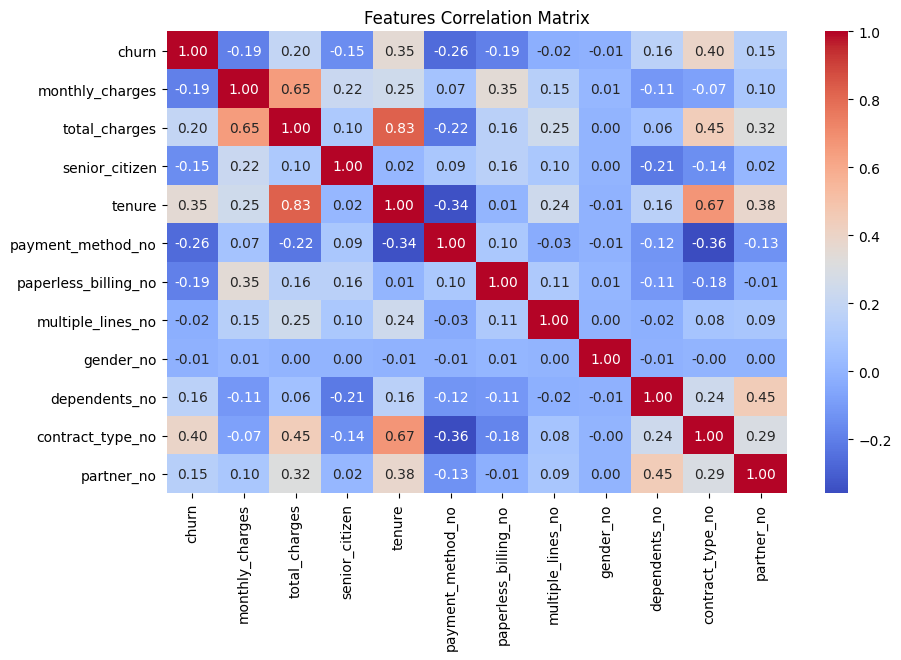

In [28]:
eda_matrix = eda.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(eda_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Features Correlation Matrix')
plt.show()

## Churning Distribution

Here is where I am attempting to gain any sort of insights whether that's splitting the attributes and viewing that way or combing them to see how they sit together. Therefore I'm looking to see what level of imbalance we could be working with, gender segmentation analysis with an emphasis on the churning group, and seeing if there's a lot of outliers or unique values with little to big weight to them thus could influence the ML section.

### Bar Chart Visual

There's a clear imbalance in favor of loyal, non-churning customers over disloyal, churning customers with the non-churning customers having about 3 times the amount of individuals comparatively to the opposing group. This goes to show that its a must to keep in mind that the models we decide to use to be aware of this and treat both groups indifferently.

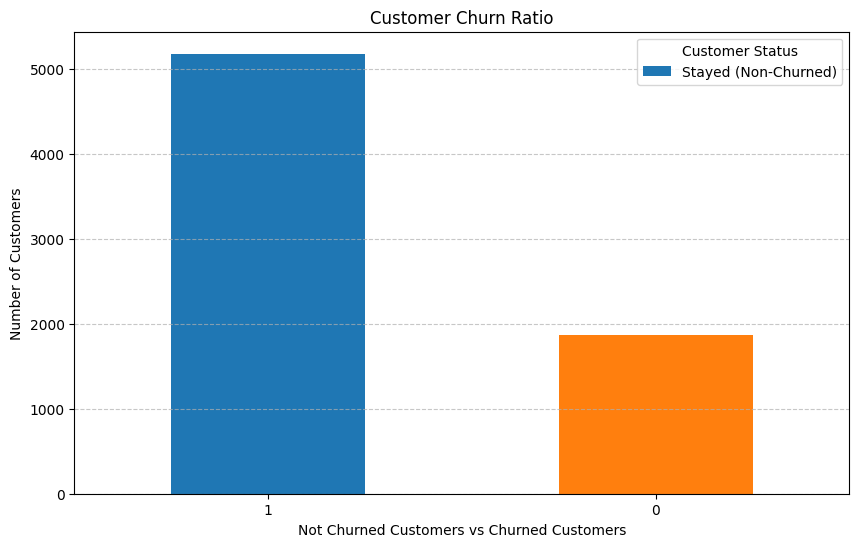

1    5174
0    1869
Name: churn, dtype: int64


In [29]:
colors = ['#1f77b4', '#ff7f0e']
churn = eda['churn'].value_counts()
churn.plot(figsize=(10, 6), kind='bar', color=colors)
plt.xlabel('Not Churned Customers vs Churned Customers')
plt.ylabel('Number of Customers')
plt.title('Customer Churn Ratio')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.legend(['Stayed (Non-Churned)', 'Left (Churned)'], title='Customer Status')
plt.show()
print(eda['churn'].value_counts())
#Remember: 1 = No Churning/Loyal Customers; 0 = churning/disloyal customers

#### Churning Customers

There are a few things I want to explore when splitting the churning & non-churning demographics. Therefore, I am going to focus mainly on the **churning demographic's** men and women separately and then both genders together. I put together a visualization function that displays barcharts and scatterplots for both groups.

In [30]:
def gender_insight(df, gender, encoding_dict):
    print("\n..... Multiple Line(s) Distribution Numerical & Visual View .....")
    
    ml = df['multiple_lines_no'].value_counts(ascending=True)
    display(ml)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    ml.plot(figsize=(10,6), kind='bar', color=colors)
    plt.xlabel('Multiple Lines')
    plt.ylabel('Count')
    plt.title(f'{gender} - Multiple Lines Distribution')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    
    legend_labels = {v: k for k, v in encoding_dict['multiple_lines'].items()}
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
    plt.legend(handles, [legend_labels[i] for i in ml.index], title=f'{gender} - Multiple Lines Distribution')
    plt.show()
    print("\n")   
    ####
    print("..... Contract Distribution Numerical & Visual View .....")
    ct = df['contract_type_no'].value_counts(ascending=True)
    print(ct)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    ct.plot(figsize=(10,6), kind='bar', color=colors)
    plt.xlabel('Contract Type')
    plt.ylabel('Count')
    plt.title(f'{gender} - Contract Type Distribution')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    legend_labels = {v: k for k, v in encoding_dict['contract_type'].items()}
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
    plt.legend(handles, [legend_labels[i] for i in ct.index], title=f'{gender} - Contract Type Distribution')
    plt.show()
    print("\n")
    ####
    print(f"..... {gender} Tenure vs Total Charges .....")
    df.plot(x='tenure', y='total_charges', kind='scatter', figsize=[10, 4])
    plt.title(f'{gender} - Tenure vs Total Charges')
    plt.show()
    
    print(f"\n..... {gender} Churn Distribution based on Total Charges .....")
    g = sns.FacetGrid(df, col="churn", row="gender_no")
    g.map_dataframe(sns.boxplot, x="total_charges")
    
    color = sns.color_palette("Set2", len(encoding_dict['gender']))
    
    legend_elements = [
        Line2D([0], [0], color=color[idx], lw=4, label=f'{key} = {value}')
        for idx, (key, value) in enumerate(encoding_dict['gender'].items())
    ]
    
    plt.legend(handles=legend_elements, title="Gender", loc="upper right")
    plt.figtext(0.5, -0.05, "Charges", ha="center", fontsize=12)
    plt.show()
    ###
    month = df['tenure'].mean()/30
    print(f"\n..... Average {gender} Churn Distribution Stats .....")
    print(f"\n The Churning {gender} Tenure averages out to {df['tenure'].mean():.1f} days.")
    print(f"\n That's about {month:.2f} months that they lasted with us.")
    print(f"\n Churning {gender} averages at a total in ${df['total_charges'].mean():.2f} in total charges.")
    print(f"\n Churning {gender} averages at a total in ${df['monthly_charges'].mean():.2f} in monthly charges.")
    display(df.describe())

In [31]:
loyal = eda[eda['churn'] == 1]
disloyal = eda[eda['churn'] == 0]
disloyalw = eda[(eda['churn'] == 0) & (eda['gender_no'] == 1)] # women who churned
disloyalm = eda[(eda['churn'] == 0) & (eda['gender_no'] == 0)] # men who churned

##### Churning Male Customers

A generalized profile overview based on the male demographic showcases that...
* 80% of men are choosing the Month-to-Month contracts
* 46% of them have multiple phone lines, 43% only has one phone line. 
* The Churning Male Tenure averages out to 577.3 days - that's about 19.24 months that they lasted with us.
* Churning Male averages at a total in \\$1623.49 in total charges and $74.05 in monthly charges.
* When observing the boxplot for total charges vs tenure (given this has a 83% correlation), plot showcases a positive skew with quite a lot of outliers on the maximum side of charges.


..... Multiple Line(s) Distribution Numerical & Visual View .....


2     90
0    406
1    434
Name: multiple_lines_no, dtype: int64

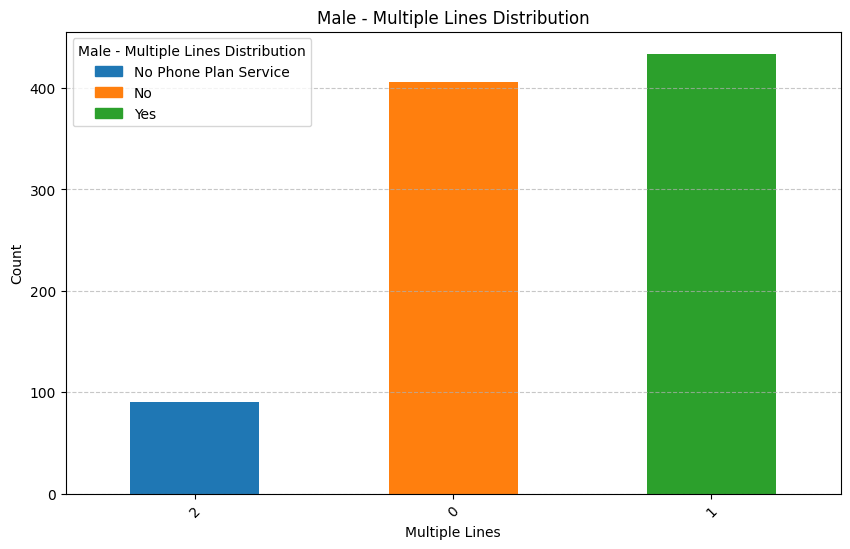



..... Contract Distribution Numerical & Visual View .....
2     26
1     91
0    813
Name: contract_type_no, dtype: int64


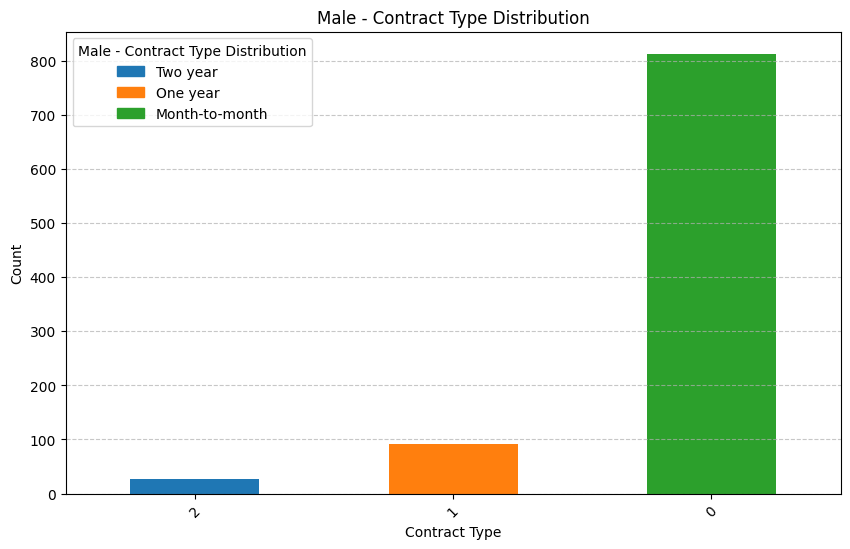



..... Male Tenure vs Total Charges .....


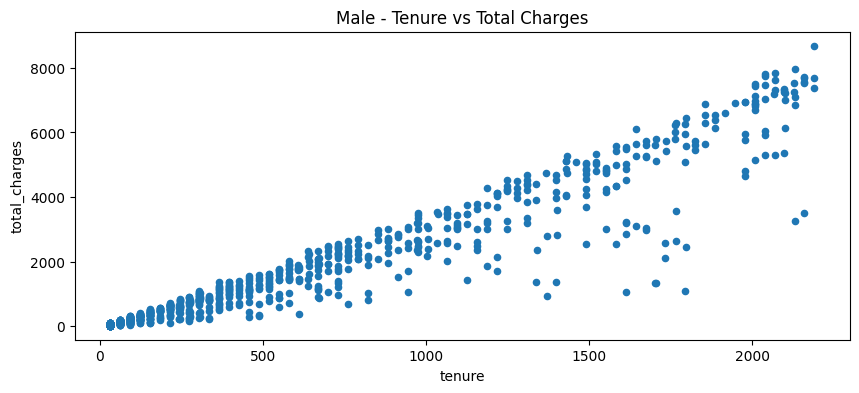


..... Male Churn Distribution based on Total Charges .....


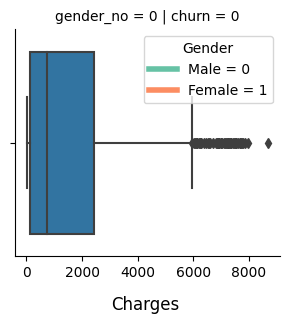


..... Average Male Churn Distribution Stats .....

 The Churning Male Tenure averages out to 577.3 days.

 That's about 19.24 months that they lasted with us.

 Churning Male averages at a total in $1623.49 in total charges.

 Churning Male averages at a total in $74.05 in monthly charges.


,churn,monthly_charges,total_charges,senior_citizen,tenure,payment_method_no,paperless_billing_no,multiple_lines_no,gender_no,dependents_no,contract_type_no,partner_no
count,930.0,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.0,930.000000,930.000000,930.000000
mean,0.0,74.049462,1623.494624,0.253763,577.312903,2.241935,0.753763,0.660215,0.0,0.173118,0.153763,0.376344
std,0.0,25.187472,1995.120814,0.435398,622.554082,1.048123,0.431050,0.646784,0.0,0.378553,0.431549,0.484729
min,0.0,19.000000,19.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.0,54.000000,114.750000,0.000000,61.000000,2.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,0.0,80.000000,740.000000,0.000000,304.000000,3.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000
75%,0.0,95.000000,2448.750000,1.000000,944.000000,3.000000,1.000000,1.000000,0.0,0.000000,0.000000,1.000000
max,0.0,118.000000,8685.000000,1.000000,2191.000000,3.000000,1.000000,2.000000,0.0,1.000000,2.000000,1.000000


In [32]:
gender_insight(disloyalm, 'Male', encoding_dict)

##### Churning Female Customers

A generalized profile overview based on the female demographic showcases that...
* 89% of women, as well, are choosing the Month-to-Month Contracts
* 47% of them have do not have multiple phone lines; 44% do have multiple lines.
* The Churning Female Tenure averages out to 517.7 days - that's about 17.26 months that they lasted with us.
* Churning Female averages at a total in \\$1440.98 in total charges and $74.80 in monthly charges.
* The boxplot shown for the female demographic showscase the same in terms of positive/normal skew with maxed charge values of outliers.


..... Multiple Line(s) Distribution Numerical & Visual View .....


2     80
1    416
0    443
Name: multiple_lines_no, dtype: int64

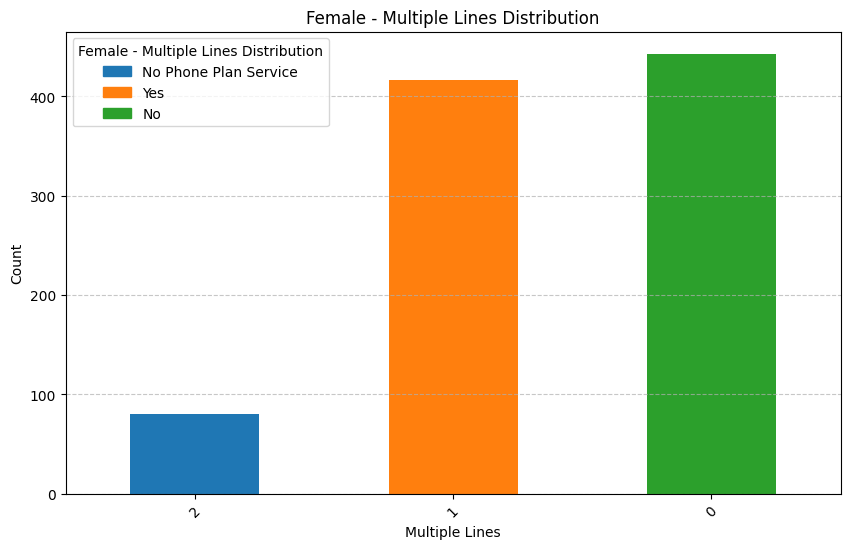



..... Contract Distribution Numerical & Visual View .....
2     22
1     75
0    842
Name: contract_type_no, dtype: int64


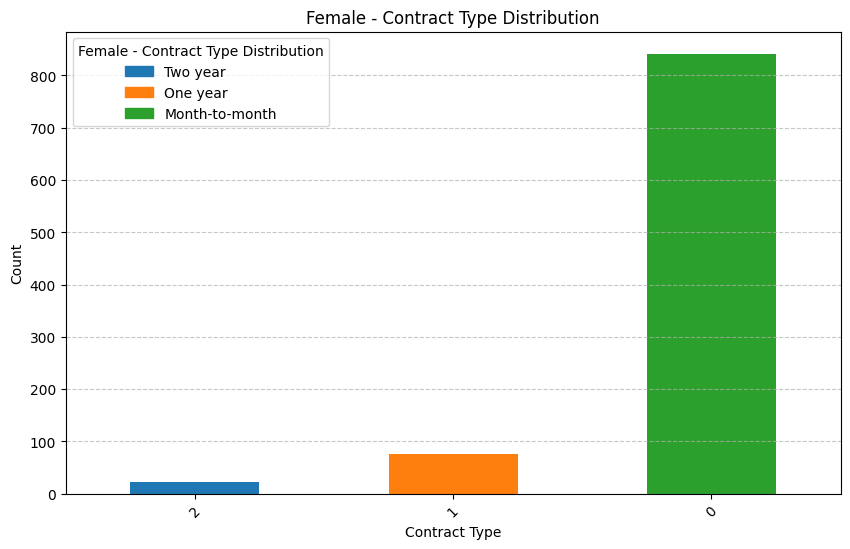



..... Female Tenure vs Total Charges .....


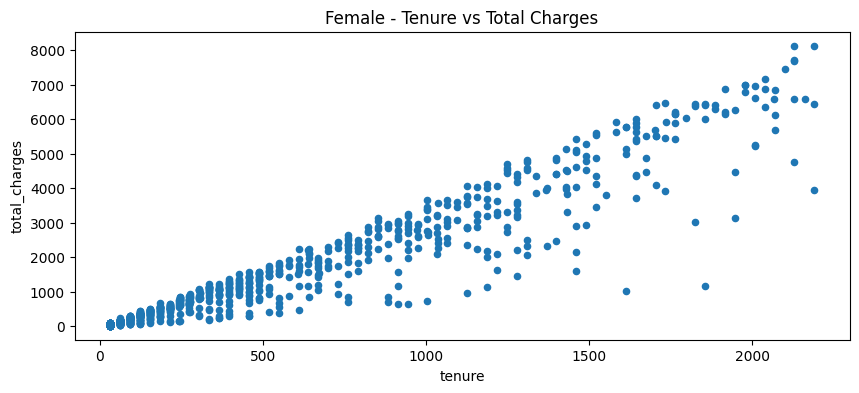


..... Female Churn Distribution based on Total Charges .....


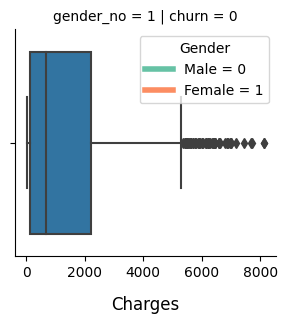


..... Average Female Churn Distribution Stats .....

 The Churning Female Tenure averages out to 517.7 days.

 That's about 17.26 months that they lasted with us.

 Churning Female averages at a total in $1440.98 in total charges.

 Churning Female averages at a total in $74.80 in monthly charges.


,churn,monthly_charges,total_charges,senior_citizen,tenure,payment_method_no,paperless_billing_no,multiple_lines_no,gender_no,dependents_no,contract_type_no,partner_no
count,939.0,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.0,939.000000,939.000000,939.000000
mean,0.0,74.804047,1440.976571,0.255591,517.678381,2.132055,0.744409,0.613419,1.0,0.175719,0.126731,0.339723
std,0.0,24.155324,1777.926112,0.436425,563.878067,1.114751,0.436425,0.638721,0.0,0.380784,0.397110,0.473868
min,0.0,19.000000,19.000000,0.000000,30.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,0.0,63.500000,143.500000,0.000000,61.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
50%,0.0,80.000000,663.000000,0.000000,275.000000,3.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000
75%,0.0,94.000000,2222.000000,1.000000,837.000000,3.000000,1.000000,1.000000,1.0,0.000000,0.000000,1.000000
max,0.0,117.000000,8128.000000,1.000000,2191.000000,3.000000,1.000000,2.000000,1.0,1.000000,2.000000,1.000000


In [33]:
gender_insight(disloyalw, 'Female', encoding_dict)

##### Churning customers and their contracts | Moving forward is the entire churning pool that includes both genders.

As for contract types, most churning customers are associated with the Month-to-Month plan, women are taking first place in this race, with a 29 difference.

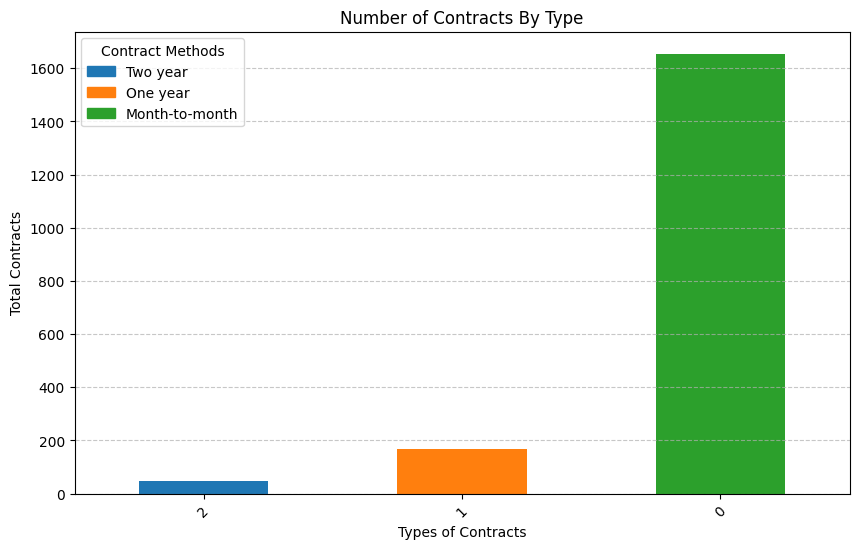

In [34]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

d = disloyal['contract_type_no'].value_counts(ascending=True)
d.plot(figsize=(10,6), kind='bar', color=colors)
plt.xlabel('Types of Contracts')
plt.ylabel('Total Contracts')
plt.title('Number of Contracts By Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
legend_labels = {v: k for k, v in encoding_dict['contract_type'].items()}
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
plt.legend(handles, [legend_labels[i] for i in d.index], title="Contract Methods")

plt.show()

In [35]:
d_gender = disloyal.groupby('contract_type_no')['gender_no'].value_counts(ascending=True).reset_index(name='count')
display(d_gender) # male - 0 | female - 1

,contract_type_no,gender_no,count
0,0,0,813
1,0,1,842
2,1,1,75
3,1,0,91
4,2,1,22
5,2,0,26


##### Churning customers and their phone plan

In terms of celluar plans, most churning men have - multiple lines, while most churning women do not have multiple lines. 

In [36]:
multiple_lines = disloyal.groupby('multiple_lines_no')['gender_no'].value_counts(ascending=True).reset_index(name='count')
display(multiple_lines) # no - 0 | yes - 1

,multiple_lines_no,gender_no,count
0,0,0,406
1,0,1,443
2,1,1,416
3,1,0,434
4,2,1,80
5,2,0,90


##### Churning customers and their social ties/titles.

This is a catch-all overview of the churning customer's social relations (having dependents, a partner and or even being a senior citizen). From what I have gathered, there's a large group of customers who are not elderly and have no dependents nor a partner with a *very very slight* imbalance favoring the men than women - to varying degrees.

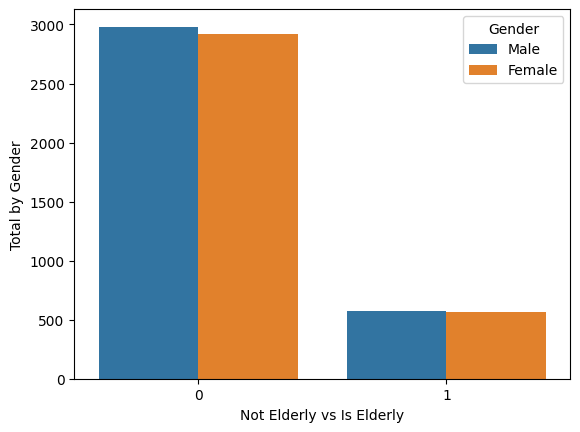

In [37]:
sns.countplot(data=eda, x='senior_citizen', hue='gender_no', hue_order=[0, 1])
plt.legend(labels=['Male', 'Female'], title='Gender')
plt.xlabel('Not Elderly vs Is Elderly')
plt.ylabel('Total by Gender')
plt.show()

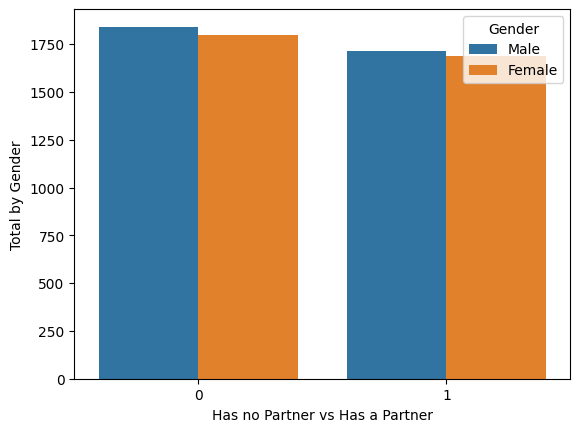

In [38]:
sns.countplot(data=eda, x='partner_no', hue='gender_no', hue_order=[0, 1])
plt.legend(labels=['Male', 'Female'], title='Gender')
plt.xlabel('Has no Partner vs Has a Partner')
plt.ylabel('Total by Gender')
plt.show()

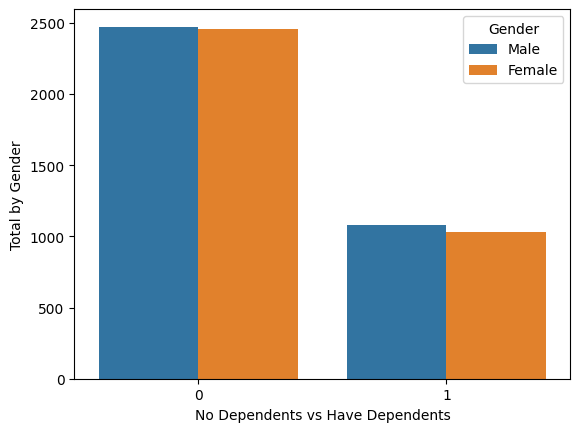

In [39]:
sns.countplot(data=eda, x='dependents_no', hue='gender_no', hue_order=[0, 1])
plt.legend(labels=['Male', 'Female'], title='Gender')
plt.xlabel('No Dependents vs Have Dependents')
plt.ylabel('Total by Gender')
plt.show()

### Churn vs Gender (or Senior Citizen) & Total Charges

The only notable thing is that there is a large distribution trend where most churning customers for both genders are compact in the lower charge \\$0-1,000 (or 2000) range.

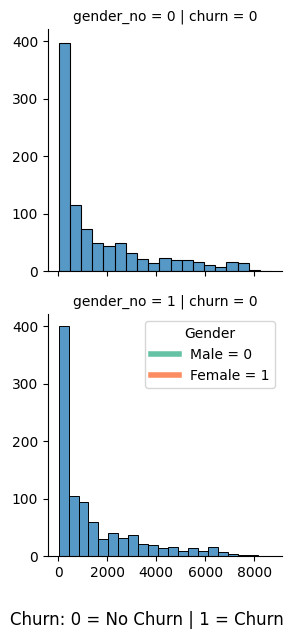

In [40]:
g = sns.FacetGrid(disloyal, col="churn",  row="gender_no")
g.map_dataframe(sns.histplot, x="total_charges")
color = sns.color_palette("Set2", len(encoding_dict['gender']))

legend_elements = [
    Line2D([0], [0], color=color[idx], lw=4, label=f'{key} = {value}')
    for idx, (key, value) in enumerate(encoding_dict['gender'].items())
]

plt.legend(handles=legend_elements, title="Gender", loc="upper right")
plt.figtext(0.5, -0.05, "Churn: 0 = No Churn | 1 = Churn", ha="center", fontsize=12)
plt.show()

The most notable thing here is that there's a clear difference between number of churning senior citizens & non-senior citizens, with most churning customers are not elderly. Non-Elderly customers also happen to show a similar pattern to the gender graph from above with high concentration in the lower charge ranges while decreasing their frequency as charges increase.

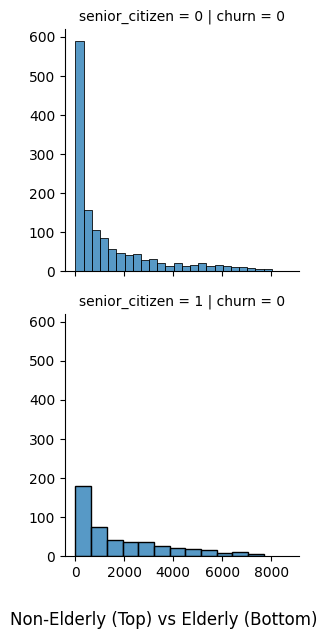

In [41]:
g = sns.FacetGrid(disloyal, col="churn",  row="senior_citizen")
g.map_dataframe(sns.histplot, x="total_charges")
color = sns.color_palette("Set2", len(encoding_dict['gender']))

legend_elements = [
    Line2D([0], [0], color=color[idx], lw=4, label=f'{key} = {value}')
    for idx, (key, value) in enumerate(encoding_dict['gender'].items())
]

plt.figtext(0.5, -0.05, "Non-Elderly (Top) vs Elderly (Bottom)", ha="center", fontsize=12)
plt.show()

## Tenure Correlations

### Tenure vs total Charges : Scatterplot

This scatterplot shows a positive correlation between tenure and total charges, as both increase linearly together. If I'm taking a guess, there's also a cluster pattern of distinct customers who pay either a high total charges (from the top right) or low-total charges (in the bottom left - or evenly in between as well but) here that possibly represent different service packages, maybe? But this definitely showcases the importance of customer retention lies in those areas. So maybe taking advantage of like the early-on customers to engaging them to switch over to a one or two year plan with a incentive-plan for a longer retention rate. Or maybe discounting long-tenure customers for their loyalty that fits their personal package?

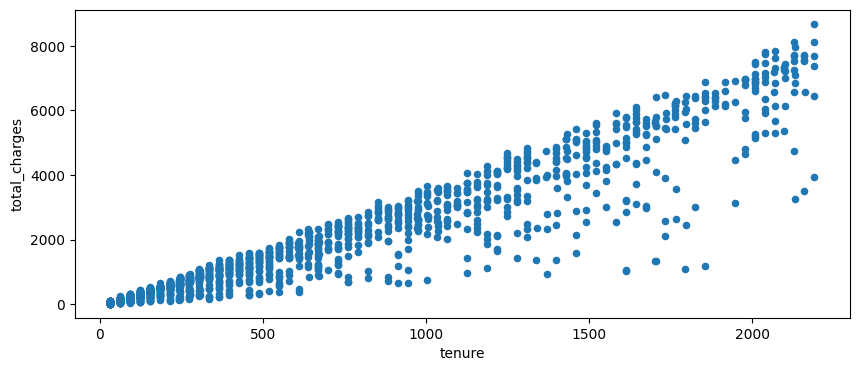

In [42]:
disloyal.plot(x='tenure', y='total_charges', kind='scatter', figsize=[10, 4])
plt.show()

## Payment Distribution

### Bar Chart Visual

For the Payment Methods visuals, churning customers definitely prefer check forms of payment such as electronic checks being first, and in second, mailed checks - not only do they prefer this the total charges peak between \\$0 - $2k for both forms of payments. Although credit card is the least prefer method with around 230 total payments, so definitely detouring away from this form of payment is ideal.

3    1071
2     308
1     258
0     232
Name: payment_method_no, dtype: int64


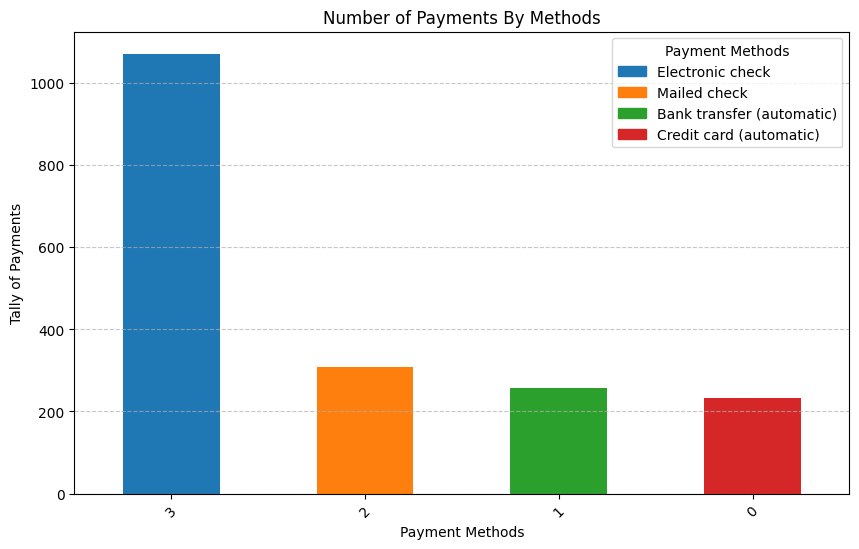

In [43]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
pymnt_types = disloyal['payment_method_no'].value_counts()
print(pymnt_types)
pymnt_types.plot(figsize=(10,6), kind='bar', color=colors)
plt.xlabel('Payment Methods')
plt.ylabel('Tally of Payments')
plt.title('Number of Payments By Methods')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

legend_labels = {v: k for k, v in encoding_dict['payment_method'].items()}
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
plt.legend(handles, [legend_labels[i] for i in pymnt_types.index], title="Payment Methods")

plt.show()

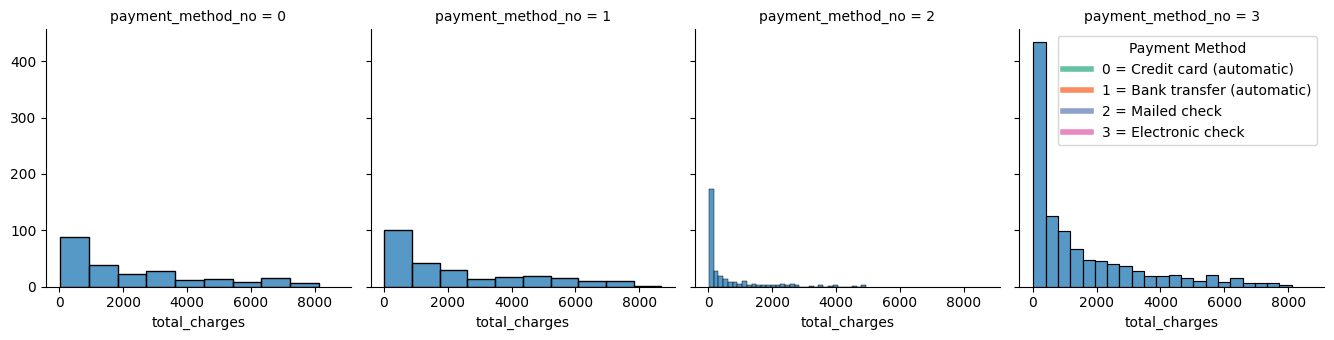

In [44]:
g = sns.FacetGrid(disloyal, col="payment_method_no", height=3.5, aspect=.96)
g.map(sns.histplot, "total_charges")
color = sns.color_palette("Set2", len(encoding_dict['payment_method']))

legend_elements = [
    Line2D([0], [0], color=color[idx], lw=4, label=f'{value} = {key}')
    for idx, (key, value) in enumerate(encoding_dict['payment_method'].items())
]

plt.legend(handles=legend_elements, title="Payment Method", loc='upper right')
plt.show()

## Contract  Distribution

### Bar Chart Visual

This clearly shows that M2M (Month-to-Month) contracts have the highest churn rate with short-tenure customers, where most people only last the first few hundred days but the longer a customer's tenure increases the less likely they're going to churn, significantly. But if they do it is around the end of their contracts after they have been with us for more or less (1k-2k days of tenure) 2-5ish years.

0    1655
1     166
2      48
Name: contract_type_no, dtype: int64


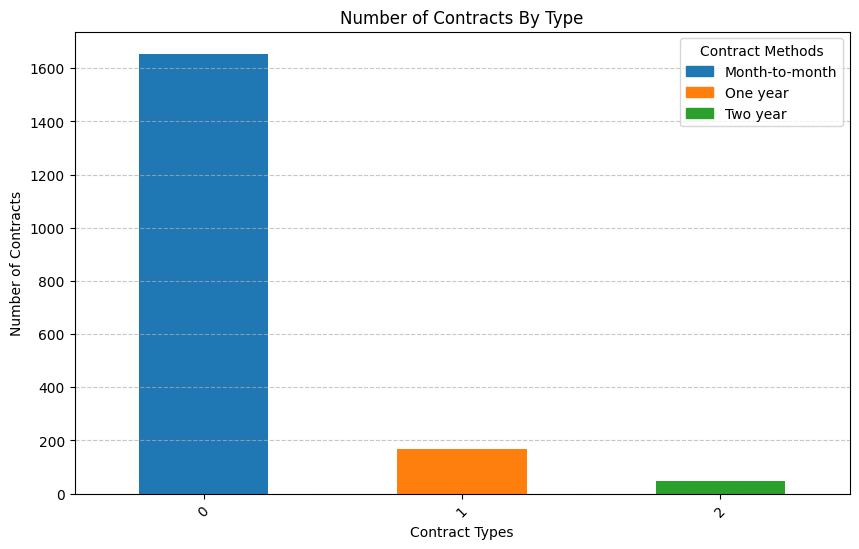

In [45]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

tenure_types = disloyal['contract_type_no'].value_counts()
print(tenure_types)
tenure_types.plot(figsize=(10,6), kind='bar', color=colors)
plt.xlabel('Contract Types')
plt.ylabel('Number of Contracts')
plt.title('Number of Contracts By Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
legend_labels = {v: k for k, v in encoding_dict['contract_type'].items()}  # Reversing the dictionary
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
plt.legend(handles, [legend_labels[i] for i in tenure_types.index], title="Contract Methods")

plt.show()

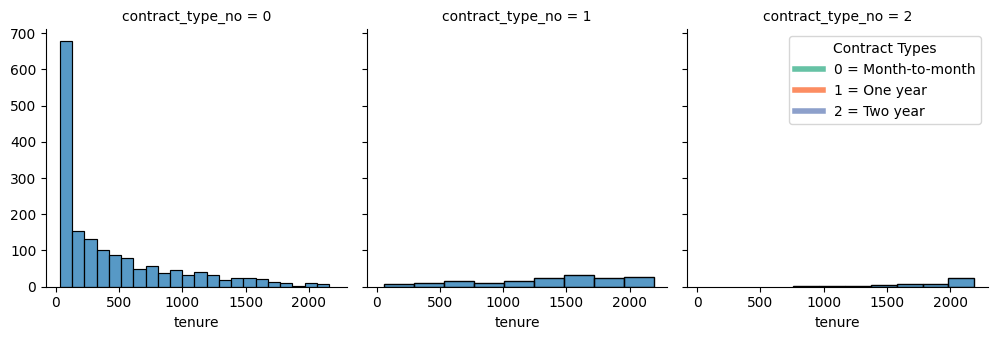

In [46]:
g = sns.FacetGrid(disloyal, col="contract_type_no", height=3.5, aspect=.96)
g.map(sns.histplot, "tenure")
color = sns.color_palette("Set2", len(encoding_dict['contract_type']))

legend_elements = [
    Line2D([0], [0], color=color[idx], lw=4, label=f'{value} = {key}')
    for idx, (key, value) in enumerate(encoding_dict['contract_type'].items())
]

plt.legend(handles=legend_elements, title="Contract Types", loc='upper right')
plt.show()

# Machine Learning

The final stretch arrives with implementing algorithms, and here are my top three choices for the task:
* Logisitic Regression
* Random Forest
* LightGBM

I am going to first gloss over the cleaned, copied dataframe that was designated for this machine learning portion and validate there are no hiccups of any kind. Next, split the data into their respective groups, features & target, and across the three sub-datasets. Then, we're going to group the numerical and categorical columns into their impromptu common-type variables in order to encode and scale the input variables and then finally release them to each of the 3 beforementioned models to see what our results will be. We're aiming for at least a 85% success rate in one of our models - so let's see what they do.

In [47]:
dataset_info(ml)

..... Duplicate Rows .....
Total Duplicates: 135


..... DataFrame Shape .....
Rows: 7043, Columns: 12


..... Missing Values .....
churn                0
monthly_charges      0
total_charges        0
contract_type        0
paperless_billing    0
payment_method       0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
tenure               0
dtype: int64 

..... DataFrame Information .....
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   churn              7043 non-null   int64 
 1   monthly_charges    7043 non-null   int64 
 2   total_charges      7043 non-null   int64 
 3   contract_type      7043 non-null   object
 4   paperless_billing  7043 non-null   object
 5   payment_method     7043 non-null   object
 6   gender             7043 non-null   object
 7   senior_c

,churn,monthly_charges,total_charges,contract_type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,multiple_lines,tenure
0,1,30,30,Month-to-month,Yes,Electronic check,Female,0,Yes,No,No Phone Plan Service,31
1,1,57,1890,One year,No,Mailed check,Male,0,No,No,No,1036
2,0,54,108,Month-to-month,Yes,Mailed check,Male,0,No,No,No,61
3,1,42,1841,One year,No,Bank transfer (automatic),Male,0,No,No,No Phone Plan Service,1371
4,0,71,152,Month-to-month,Yes,Electronic check,Female,0,No,No,No,61
5,0,100,820,Month-to-month,Yes,Electronic check,Female,0,No,No,Yes,245
6,1,89,1949,Month-to-month,Yes,Credit card (automatic),Male,0,No,Yes,Yes,671
7,1,30,302,Month-to-month,No,Mailed check,Female,0,No,No,No Phone Plan Service,306
8,0,105,3046,Month-to-month,Yes,Electronic check,Female,0,Yes,No,Yes,853
9,1,56,3488,One year,No,Bank transfer (automatic),Male,0,No,Yes,No,1888


..... DataFrame's Sampled Rows .....


,churn,monthly_charges,total_charges,contract_type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,multiple_lines,tenure
9,1,56,3488,One year,No,Bank transfer (automatic),Male,0,No,Yes,No,1888
6407,1,56,932,One year,No,Mailed check,Female,0,No,No,No,457
3567,0,90,1208,Month-to-month,Yes,Credit card (automatic),Female,0,Yes,Yes,No,426
4245,1,20,1276,Two year,No,Mailed check,Male,0,Yes,Yes,No,1918
246,1,65,2532,One year,No,Mailed check,Male,0,No,No,Yes,1248
4855,1,104,6606,Two year,Yes,Credit card (automatic),Male,0,Yes,No,No,1949
2672,1,20,563,One year,No,Bank transfer (automatic),Male,0,No,No,No,822
5770,1,68,2479,One year,No,Credit card (automatic),Female,0,Yes,No,Yes,1126
2484,1,20,256,Month-to-month,No,Mailed check,Male,0,Yes,Yes,No,365
5331,1,54,2375,Two year,Yes,Credit card (automatic),Male,0,Yes,Yes,No Phone Plan Service,1340


In [48]:
target = ml['churn']
features = ml.drop('churn', axis=1)

train_features, split_features, train_target, split_target = train_test_split(
    features, target, test_size=0.40, random_state=120)

valid_features, test_features, valid_target, test_target = train_test_split(
    split_features, split_target, test_size=0.25, random_state=120)

#Train Datasets' Shapes
print(f'train_features:', train_features.shape)
print(f'train_target:', train_target.shape)

#Validation Datasets' Shapes
print(f'valid_features:', valid_features.shape)
print(f'valid_target:', valid_target.shape)

#Testing Datasets' Shapes
print(f'test_features:', test_features.shape)
print(f'test_target:', test_target.shape)

train_features: (4225, 11)
train_target: (4225,)
valid_features: (2113, 11)
valid_target: (2113,)
test_features: (705, 11)
test_target: (705,)


In [49]:
ml.columns

Index(['churn', 'monthly_charges', 'total_charges', 'contract_type',
       'paperless_billing', 'payment_method', 'gender', 'senior_citizen',
       'partner', 'dependents', 'multiple_lines', 'tenure'],
      dtype='object')

In [50]:
cat_ft = ['contract_type', 'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents', 'multiple_lines']
num_ft = ['monthly_charges', 'total_charges', 'senior_citizen', 'tenure']

encoder = OneHotEncoder(handle_unknown='ignore', sparse=True)
encoder.fit(train_features[cat_ft])

train_cat_encoded = encoder.transform(train_features[cat_ft])
valid_cat_encoded = encoder.transform(valid_features[cat_ft])
test_cat_encoded = encoder.transform(test_features[cat_ft])

scaler = StandardScaler()
scaler.fit(train_features[num_ft])

train_num_scaled = scaler.transform(train_features[num_ft])
valid_num_scaled = scaler.transform(valid_features[num_ft])
test_num_scaled = scaler.transform(test_features[num_ft])

#remember hstack for future ml tasks cause this helps w/ merging
train_features = hstack([train_cat_encoded, train_num_scaled])
valid_features = hstack([valid_cat_encoded, valid_num_scaled])
test_features = hstack([test_cat_encoded, test_num_scaled])

## Model 1 - Logistic Regression

In [51]:
param = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']}

lr = LogisticRegression(random_state=120, class_weight='balanced')
lr_search = RandomizedSearchCV(lr, param_distributions=param, cv=5, scoring='roc_auc', n_iter=10, random_state=120)

lr_search.fit(train_features, train_target)
valid_predictions = lr_search.best_estimator_.predict(valid_features)
valid_probs = lr_search.best_estimator_.predict_proba(valid_features)[:, 1]

accuracy = accuracy_score(valid_target, valid_predictions)
auc_roc = roc_auc_score(valid_target, valid_probs)

print("Logistic Regression Best Params:", lr_search.best_params_)
print(f"Logistic Regression Train Accuracy: {accuracy:.4f}")
print(f"Logistic Regression Train AUC-ROC: {auc_roc:.4f}")

Logistic Regression Best Params: {'solver': 'liblinear', 'C': 100}
Logistic Regression Train Accuracy: 0.7407
Logistic Regression Train AUC-ROC: 0.8398


## Model 2 - Random Forest

In [52]:
param = {
    'n_estimators': [10, 50, 100],
    'max_depth': [40, 30, 50],
    'max_features': ['log2', 'sqrt', 'auto']}

rf = RandomForestClassifier(random_state=120, class_weight='balanced')
rf_search = RandomizedSearchCV(rf, param_distributions=param, cv=5, scoring='roc_auc', n_iter=10, random_state=120)

rf_search.fit(train_features, train_target)
valid_predictions = rf_search.best_estimator_.predict(valid_features)
valid_probs = rf_search.best_estimator_.predict_proba(valid_features)[:, 1]

accuracy = accuracy_score(valid_target, valid_predictions)
auc_roc = roc_auc_score(valid_target, valid_probs)

print("Random Forest Best Params:", rf_search.best_params_)
print(f"Random Forest Train Accuracy: {accuracy:.4f}")
print(f"Random Forest Train AUC-ROC: {auc_roc:.4f}")

Random Forest Best Params: {'n_estimators': 50, 'max_features': 'auto', 'max_depth': 50}
Random Forest Train Accuracy: 0.7951
Random Forest Train AUC-ROC: 0.8263


## Model 3 - Light GBM

In [53]:
param = {
    'num_leaves': [35, 50, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0]
}

lgb_model = LGBMClassifier(random_state=120, is_unbalance=True)
lgb_search = RandomizedSearchCV(lgb_model, param_distributions=param, cv=5, scoring='roc_auc', n_iter=10, random_state=120)

lgb_search.fit(train_features, train_target, eval_set=[(valid_features, valid_target)], early_stopping_rounds=10, verbose=100)
valid_probs = lgb_search.best_estimator_.predict_proba(valid_features)[:, 1]
valid_preds = lgb_search.best_estimator_.predict(valid_features)

auc_roc = roc_auc_score(valid_target, valid_probs)
accuracy = accuracy_score(valid_target, valid_preds)

print("LightGBM Best Params:", lgb_search.best_params_)
print(f"LightGBM Train Accuracy: {accuracy:.4f}")
print(f"LightGBM Train AUC-ROC: {auc_roc:.4f}")

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.44395


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.446521


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.445225


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.446592


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.444106


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'earl

[100]	valid_0's binary_logloss: 0.392823


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.398032


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.398987


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.401808


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.391281


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'earl

[100]	valid_0's binary_logloss: 0.387913


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'earl

[100]	valid_0's binary_logloss: 0.447558
[200]	valid_0's binary_logloss: 0.432837


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.448853
[200]	valid_0's binary_logloss: 0.436585


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.448467
[200]	valid_0's binary_logloss: 0.436234


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.449213
[200]	valid_0's binary_logloss: 0.431458


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.446007
[200]	valid_0's binary_logloss: 0.430658


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'earl

[100]	valid_0's binary_logloss: 0.445184


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.447791


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.446968


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.44811


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.444969


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'earl

[100]	valid_0's binary_logloss: 0.387913


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'earl

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'earl

[100]	valid_0's binary_logloss: 0.379579
LightGBM Best Params: {'subsample': 1.0, 'num_leaves': 35, 'n_estimators': 200, 'learning_rate': 0.1}
LightGBM Train Accuracy: 0.8221
LightGBM Train AUC-ROC: 0.8928


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


## Final Testing Model

In [54]:
test_probs = lgb_search.best_estimator_.predict_proba(test_features)[:, 1]
test_preds = lgb_search.best_estimator_.predict(test_features)

test_auc_roc = roc_auc_score(test_target, test_probs)
test_accuracy = accuracy_score(test_target, test_preds)

# Print the results
print(f"LightGBM Test AUC-ROC Score: {test_auc_roc:.4f}")
print(f"LightGBM Test Accuracy: {test_accuracy:.4f}")

LightGBM Test AUC-ROC Score: 0.8611
LightGBM Test Accuracy: 0.7957


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


In [55]:
test_predictions = rf_search.best_estimator_.predict(test_features)
test_probs = rf_search.best_estimator_.predict_proba(test_features)[:, 1]

accuracy = accuracy_score(test_target, test_predictions)
auc_roc = roc_auc_score(test_target, test_probs)

print(f"Random Forest Test Accuracy: {accuracy:.4f}")
print(f"Random Forest Test AUC-ROC: {auc_roc:.4f}")

Random Forest Test Accuracy: 0.7830
Random Forest Test AUC-ROC: 0.8105


In [56]:
test_predictions = lr_search.best_estimator_.predict(test_features)
test_probs = lr_search.best_estimator_.predict_proba(test_features)[:, 1]

accuracy = accuracy_score(test_target, test_predictions)
auc_roc = roc_auc_score(test_target, test_probs)

print(f"Logistic Regression Test Accuracy: {accuracy:.4f}")
print(f"Logisitic Regression Test AUC-ROC: {auc_roc:.4f}")

Logistic Regression Test Accuracy: 0.7262
Logisitic Regression Test AUC-ROC: 0.8178


# Conclusion

All models did exceptionally well to have a B-rating success rate, and they all didn't take much rendering time either. The LightGBM definitely hit the threshold that was expected for the models while the RandomForestClassifier & Logisitic Regression models was lagging behind by 4% less than the LightGBM model when implenting the testing subset data. 


With that being said, I think all models are decent but LightGBM could do the job well when indicating the tell-tale signs of a churning customers. When the model notices those signs are active there should be some incentives set in place to guage a customer's seriousness on churning, such as:

Presenting like *a package bundle* or *payment incentives* to customers who've selected the month-to-month contracts. Meaning like if we know that Person A who has a M2M contract has both cell and internet plans maybe nudging a bundling service so they can save money. And or, encouraging an individual right before their current month contract ends, to convert over to a year-contract and rewarding them with taking off \\$5 from their plans so they know or feel like they're saving time (avoiding contract renewal) and money ($60 for the year) by doing so.

If that's a bit costly, maybe a smaller implementation on trying out incentive-based surveys when a churning customer visits the company's page or app or even after a customer service call where they can get a BOGO or $20 OFF deal at a retail store or restaurant. That way you can build a stronger relationship with the person that makes them feel special and taken cared of as you're looking out for their best interests.

# Solution Report

All the plan's steps were performed but one, which was the approach to transforming all 4 datasets into 1 and retaining the appropriate amount of customer data. 

Originally, the plan was to isolate the customer's numerical id by using a Regular Expression that strips the underscore and it's appending numerical or alphabet sequence *following the initial numerical sequence* (i.e. 1234_XJFTG & 1234_19 --> 1234 & 1234). Therefore, upon combining, I would be able to retain the data across all dataframes all in one place and proceed with the rest of the plan's steps.

However, after conversing with my data science colleague, the direction of isolating and retaining the appropriate customer's info was slightly adjusted by simplying converting the customer's datatype from object to string and retaining original id that way and then proceeding with the rest of the plan. But overall, difficulty lie exactly in choosing which customer's info was important or not and the way this was resolved was going over the instructions again and making sure I am understanding the problem and data very well. 